In [ ]:
#!pip install matplotlib --upgrade
# !pip install lightgbm --upgrade
#!pip install scikit-optimize

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold 
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import fbeta_score,make_scorer

## Import Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/belajar python/case study/rakamin_home_credit/data/clean/app_train_72.csv",index_col = "sk_id_curr")
df.head()

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Splitting

In [ ]:
## stratified shuffle
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 71), (61503, 71), (246008,), (61503,))

## Preprocessing

In [ ]:
document_col = X_train.loc[:,"flag_document_2":"flag_document_21"].columns.to_list()
reg_col = X_train.loc[:,"reg_region_not_live_region":'live_city_not_work_city'].columns.to_list()
flag_contact = X_train.loc[:,"flag_mobil":"flag_email"].columns.to_list()
passthrough_col = document_col + reg_col + flag_contact

num_prep_col = X_train.select_dtypes(include = np.number).columns.to_list()
for i in passthrough_col:
    num_prep_col.remove(i)

In [ ]:
#COMMON
num_pipe = Pipeline([
    ('impute',SimpleImputer(strategy="median")),
    ("Power", PowerTransformer())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("ordinal",OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', num_pipe, num_prep_col),
    ('categoric', cat_pipe, X_train.select_dtypes(include = "object").columns.to_list()),
],remainder = "passthrough")

## LGBM

In [ ]:
lgbm_params = {
    'algo__colsample_bytree': Real(low=0.1, high=1, transform='identity'),
    'algo__subsample': Real(low=0.2, high=1, transform='identity'),
    "algo__num_leaves" : Integer(low = 32,high = 80,transform  = "identity"),
    'algo__reg_alpha': Real(low=0.01, high=10, prior='uniform', transform='identity'),
    'algo__reg_lambda': Real(low=0.01, high=10, prior='uniform', transform='identity'),
    "algo__scale_pos_weight" : Real(low = 1,high = 11,prior = 'uniform',transform = "identity")
}

pipeline_lgbm = Pipeline([
    ('prep', preprocessor),
    ('algo', LGBMClassifier(random_state=42,objective = "binary"))
])

scorer = make_scorer(fbeta_score,beta = 1)

model_lgbm = BayesSearchCV(pipeline_lgbm, lgbm_params, cv=4, scoring=scorer,
                          n_iter=25, n_jobs=-1, verbose=1, random_state=42)
model_lgbm.fit(X_train, y_train)

print(model_lgbm.best_params_)
print(model_lgbm.score(X_train, y_train), model_lgbm.best_score_, model_lgbm.score(X_test, y_test))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


OrderedDict([('algo__colsample_bytree', 0.8311563895216271), ('algo__num_leaves', 40), ('algo__reg_alpha', 5.984490304346159), ('algo__reg_lambda', 8.029620163751542), ('algo__scale_pos_weight', 6.230523280543836), ('algo__subsample', 0.2763640313719948)])
0.33206908228919746 0.2960345940096627 0.30613370089593384


In [ ]:
from sklearn.metrics import classification_report
def clfr_plot(model, X_train, y_train, X_test, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    clf_report_train = classification_report(
        y_train, model.predict(X_train), output_dict=True)
    clf_report_test = classification_report(
        y_test, model.predict(X_test), output_dict=True)

    sns.heatmap(pd.DataFrame(
        clf_report_train).iloc[:-1, :].T, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5,ax = axes[0],cbar = False)
    sns.heatmap(pd.DataFrame(
        clf_report_test).iloc[:-1, :].T, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5,ax = axes[1])
    
    axes[0].set_title("Train Set")
    axes[1].set_title("Test Set")
    plt.suptitle("Classification report")
    plt.show()

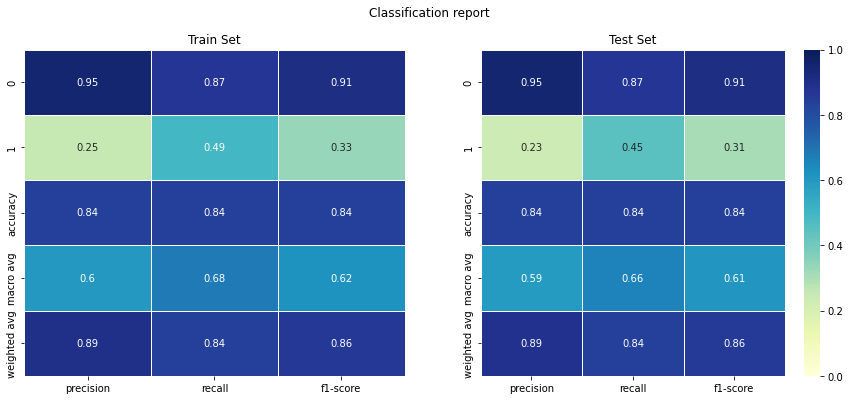

In [ ]:
clfr_plot(model_lgbm, X_train, y_train, X_test, y_test)

In [ ]:
y_sample = y_test.sample(100)
y_sample.value_counts()

0    94
1     6
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


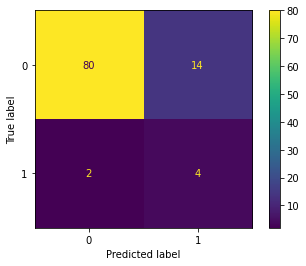

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_lgbm,X_test.loc[y_sample.index], y_sample)

In [ ]:
import joblib

joblib.dump(model_lgbm,"/content/drive/MyDrive/belajar python/case study/rakamin_home_credit/model/model_lgbm.pkl")

['/content/drive/MyDrive/belajar python/case study/rakamin_home_credit/model/model_lgbm.pkl']